In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
!pip install yfinance --upgrade --no-cache-dir
from pandas_datareader import data as pdr
import yfinance as yf
from collections import deque
import random
!pip install tensorflow 
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()


In [2]:
yf.pdr_override()
df_full = pdr.get_data_yahoo("CAT", start="2009-01-01", end="2017-12-31").reset_index()
df_full.to_csv('CAT.csv',index=False)
df_full.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-12-31,43.700001,45.099998,43.700001,44.669998,31.095800,6277400
1,2009-01-02,44.910000,46.980000,44.709999,46.910000,32.655109,7117200
2,2009-01-05,46.900002,47.119999,45.810001,46.080002,32.077332,11098700
3,2009-01-06,46.790001,46.799999,45.410000,45.799999,31.882410,10863400
4,2009-01-07,45.220001,45.599998,43.200001,43.669998,30.399675,9026500


In [3]:
df= df_full.copy()
name = 'Q-learning agent'
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            else:
                print ('day %d, hold on, total balance %f,' 
                      % (t, initial_money)) 
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
epoch: 10, total rewards: 774.809896.3, cost: 0.042204, total money: 10086.239889
epoch: 20, total rewards: 632.119911.3, cost: 0.055534, total money: 10632.119911
epoch: 30, total rewards: 746.199955.3, cost: 0.031159, total money: 10056.019947
epoch: 40, total rewards: 456.799944.3, cost: 0.032561, total money: 10315.299944
epoch: 50, total rewards: 371.599937.3, cost: 0.058562, total money: 10230.099937
epoch: 60, total rewards: 232.619921.3, cost: 0.030268, total money: 10232.619921
epoch: 70, total rewards: 290.869898.3, cost: 0.029512, total money: 10290.869898
epoch: 80, total rewards: 204.419907.3, cost: 0.043352, total money: 10204.419907
epoch: 90, total rewards: 130.989923.3, cost: 0.028148, total money: 10130.989923
epoch: 100, total rewards: 77.019903.3, cost: 0.026387, total money: 10077.019903
epoch: 110, total rewards: 100.529894.3, cost: 0.0

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 8: buy 1 unit at price 41.400002, total balance 9958.599998
day 9, sell 1 unit at price 39.349998, investment -4.951698 %, total balance 9997.949997,
day 10: buy 1 unit at price 39.389999, total balance 9958.559998
day 12, sell 1 unit at price 38.320000, investment -2.716425 %, total balance 9996.879997,
day 17: buy 1 unit at price 32.320000, total balance 9964.559998
day 19, sell 1 unit at price 31.850000, investment -1.454206 %, total balance 9996.409998,
day 29: buy 1 unit at price 31.020000, total balance 9965.389997
day 32: buy 1 unit at price 28.440001, total balance 9936.949997
day 34: buy 1 unit at price 26.660000, total balance 9910.289997
day 36, sell 1 unit at price 26.040001, investment -16.054157 %, total balance 9936.329998,
day 37, sell 1 unit at price 25.030001, investment -11.990154 %, total balance 9961.359999,
day 39, sell 1 unit at price 24.610001, investment -7.689420 %, total balance 9985.969999,
day 42: buy 1 unit at price 25.440001, total balance 9960.529999

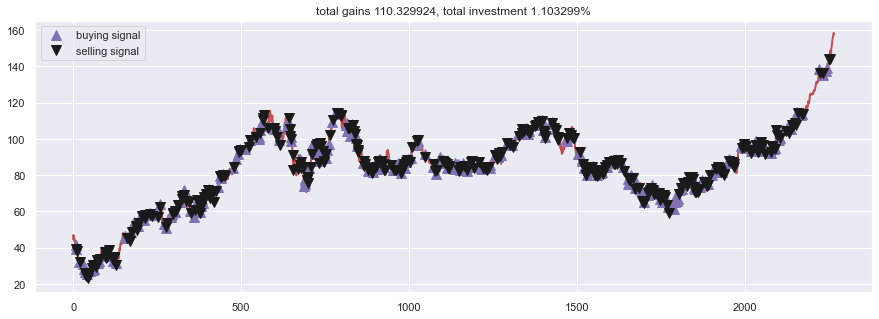

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()
